# Using other compositional differentiation methods in scCODA

While the scCODA package is mainly aimed at providing an implementation and interface of the scCODA model ([Büttner, Ostner et al., 2021](https://www.nature.com/articles/s41467-021-27150-6)),
the module `sccoda.models.other_models` contains a variety of wrappers for other compositional differentiation methods
that can be used with scCODA's data handling pipeline.

The available methods are:

- A fully Bayesian Dirichlet-Multinomial model without spike-and-slab priors.
- The SCDC model ([Cao et al., 2019](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3211-9))
- A (non-compositional) Poisson regression model
- A model using the centered logratio (CLR) transform together with a generalized linear model
- A (non-compositional) t-test
- A CLR transform together with a t-test
- The ALDEx2 model for compositional differentiation in microbial data ([Fernandes et al., 2014](https://microbiomejournal.biomedcentral.com/articles/10.1186/2049-2618-2-15))
- An additive logratio (ALR) transform of the data paired with a t-test
- An ALR transform of the data paired with a Wilcoxon rank-sum test
- The ANCOM model for compositional differentiation in microbial data ([Mandal et al., 2015](https://www.tandfonline.com/toc/zmeh20/current))
- The Bias-corrected ANCOM model for compositional differentiation in microbial data ([Lin, Peddada, 2020](https://www.nature.com/articles/s41467-020-17041-7)]
- A Dirichlet regression approach ([Maier, 2014](https://epubdev.wu.ac.at/4077/))
- Beta-Binomial modeling via corncob ([Martin e al., 2019](https://arxiv.org/abs/1902.02776))

**Note: Some methods (SCDC, ALDEx2, Dirichlet Regression, ANCOMBC, Beta-Binomial) require an R environment with the according packages installed**

**NOTE: If you want to run this tutorial, make sure to have [scikit-bio](https://github.com/biocore/scikit-bio) installed. It is not automatically included when installing via pip.**

This tutorial aims at showcasing the use of some of these methods.

## Setup and data handling

We use the salmonella infection data from [Haber et al., 2017](https://www.nature.com/articles/nature24489).

In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import patsy as pt
import numpy as np

from sccoda.model import other_models as om
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

In [2]:
# Get some data (Salmonella infection from Haber et al.)
cell_counts = scd.haber()

# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_all.obs["Condition"] = data_all.obs["Mouse"].str.replace(r"_[0-9]", "")

# Select control and salmonella data
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])]
print(data_salm)

View of AnnData object with n_obs × n_vars = 6 × 8
    obs: 'Mouse', 'Condition'


<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

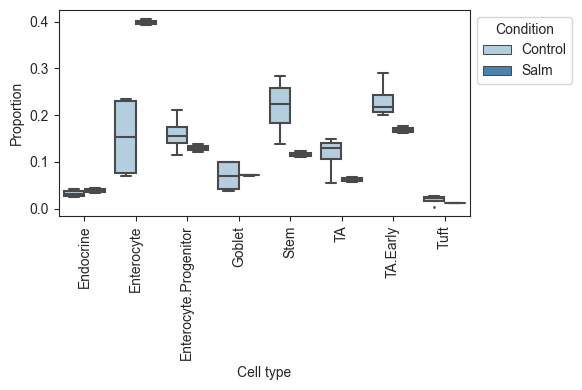

In [3]:
viz.boxplots(data_salm, feature_name="Condition")

## The ancom model

Using the ancom model ([Mandal et al., 2015](https://www.tandfonline.com/toc/zmeh20/current)) with scCODA is straightforward.
We use the implementation in [scikit-bio](http://scikit-bio.org/) and also its output format:

The column "Reject null hypothesis" shows the columns that change significantly according to ancom

In [4]:
ancom_model = om.AncomModel(data_salm, covariate_column="Condition")
ancom_model.fit_model()
print(ancom_model.ancom_out)

Trying to set attribute `.X` of view, copying.


(                       W  Reject null hypothesis
Endocrine              0                   False
Enterocyte             0                   False
Enterocyte.Progenitor  0                   False
Goblet                 0                   False
Stem                   0                   False
TA                     0                   False
TA.Early               0                   False
Tuft                   0                   False, Percentile              0.0     25.0    50.0    75.0    100.0  0.0     25.0   \
Group                 Control Control Control Control Control   Salm    Salm   
Endocrine                 5.0   20.75    31.0   38.25    45.0   32.0   33.25   
Enterocyte               46.0   55.75    78.5  128.75   221.0  332.0  342.25   
Enterocyte.Progenitor    23.0  107.75   162.0  190.50   198.0  113.0  113.75   
Goblet                   20.0   32.00    36.0   58.00   124.0   59.0   61.00   
Stem                     50.0  110.75   185.0  241.75   250.0   90.0   96.75 

## The ALDEx2 model

The ALDEx2 model ([Fernandes et al., 2014](https://microbiomejournal.biomedcentral.com/articles/10.1186/2049-2618-2-15))
requires an R installation with the *ALDEx2* package available.
The paths `r_home` and `r_path` must point to the installation folder and the R executable of your R version.

The result columns show the p-values of various tests (see the [documentation](https://bioconductor.org/packages/release/bioc/vignettes/ALDEx2/inst/doc/ALDEx2_vignette.pdf) of ALDEx2 for details)

In [5]:
r_home = "/Library/Frameworks/R.framework/Resources"
r_path = "/Library/Frameworks/R.framework/Resources/bin/R"

In [6]:
aldex2_model = om.ALDEx2Model(data_salm, covariate_column="Condition")
aldex2_model.fit_model(r_home=r_home, r_path=r_path)
print(aldex2_model.result)

R[write to console]: operating in serial mode

R[write to console]: computing center with all features



      we.ep    we.eBH     wi.ep    wi.eBH
1  0.385566  0.520241  0.519792  0.670258
2  0.055019  0.190518  0.133333  0.419444
3  0.554758  0.649357  0.742708  0.839306
4  0.549451  0.649280  0.890104  0.910625
5  0.045055  0.170609  0.146875  0.427778
6  0.211257  0.380195  0.436458  0.651677
7  0.165477  0.311701  0.277604  0.509593
8  0.644732  0.715048  0.594792  0.750084


## The SCDC model

For using the SCDC model ([Cao et al., 2019](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3211-9)),
an R environment with the package *scdney* (available on [github](https://github.com/SydneyBioX/scdney)) is required.

Using the model is similar to the other ones, the "p.values" column shows significances:

In [7]:
scdc_model = om.scdney_model(data_salm, covariate_column="Condition")
result, _ = scdc_model.analyze(r_home=r_home, r_path=r_path)
print(result)

R[write to console]: ── Attaching packages ────────────────────────────────────────── scdney 0.2.0 ──

R[write to console]: ✔ scMerge    1.10.0     ✔ scClust    0.3.0 
✔ scClassify 1.6.0      ✔ Cepo       1.0.0 
✔ CiteFuse   1.6.0      ✔ scHOT      1.6.0 
✔ scDC       0.1.0      

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ stringr::boundary() masks graph::boundary()
✖ dplyr::collapse()   masks IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::desc()       masks IRanges::desc()
✖ tidyr::expand()     masks S4Vectors::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::first()      masks S4Vectors::first(

[1] "Calculating sample proportion..."
[1] "Calculating bootstrap proportion..."
[1] "Calculating BCa ..."
[1] "Calculating z0 ..."
[1] "Calculating acc ..."
[1] "fitting GLM... 10"
[1] "fitting GLM... 20"
[1] "fitting GLM... 30"
[1] "fitting GLM... 40"
[1] "fitting GLM... 50"
[1] "fitting GLM... 60"
[1] "fitting GLM... 70"
[1] "fitting GLM... 80"
[1] "fitting GLM... 90"
[1] "fitting GLM... 100"
                                              term  estimate  std.error  \
0                                      (Intercept)  3.340425   0.130826   
1                         cellTypescell_Enterocyte  1.318058   0.151683   
2              cellTypescell_Enterocyte.Progenitor  1.573899   0.145437   
3                             cellTypescell_Goblet  0.643168   0.167195   
4                               cellTypescell_Stem  1.779897   0.138821   
5                                 cellTypescell_TA  1.324436   0.145850   
6                           cellTypescell_TA.Early  1.944167   0.143707   
7

## The simple Dirichlet-Multinomial model

Using the simple Dirichlet model is similar to using the scCODA model. Only HMC sampling is available for inference.

Significantly changing are all cell types where 0 is not included in the high density interval (HDI)

In [10]:
K = data_salm.X.shape[1]
formula = "Condition"

cell_types = data_salm.var.index.to_list()

# Get count data
data_matrix = data_salm.X.astype("float32")

# Build covariate matrix from R-like formula
covariate_matrix = pt.dmatrix(formula, data_salm.obs)
covariate_names = covariate_matrix.design_info.column_names[1:]
covariate_matrix = covariate_matrix[:, 1:]

# Init model. Baseline index is always the last cell type
mod = om.SimpleModel(covariate_matrix=np.array(covariate_matrix), data_matrix=data_matrix,
                     cell_types=cell_types, covariate_names=covariate_names, formula=formula,
                     reference_cell_type=4)

# Run HMC sampling
result_simple = mod.sample_hmc()

result_simple.summary_extended()

2021-11-28 19:36:25.016681: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_DOUBLE } } inputs { dtype: DT_DOUBLE shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2000 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.99" } l1_cache_size: 49152 l2_cache_size: 524288 l3_cache_size: 6291456 memory_size: 268435456 } outputs { dtype: DT_DOUBLE shape { unknown_rank: true } }
2021-11-28 19:36:25.038579: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_DOUBLE } } inputs { dtype: DT_DOUBLE shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2000 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX 

MCMC sampling finished. (283.799 sec)
Acceptance rate: 69.1%
Compositional Analysis summary (extended):

Data: 6 samples, 8 cell types
Reference index: 4
Formula: Condition

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 283.799 sec. Acceptance rate: 69.1%

Intercepts:
                       Final Parameter  HDI 3%  HDI 97%     SD  \
Cell Type                                                        
Endocrine                        1.043   0.307    1.726  0.387   
Enterocyte                       2.320   1.723    2.930  0.323   
Enterocyte.Progenitor            2.483   1.834    3.075  0.334   
Goblet                           1.616   0.924    2.227  0.351   
Stem                             2.746   2.179    3.371  0.317   
TA                               2.161   1.467    2.807  0.355   
TA.Early                         2.849   2.233    3.440  0.324   
Tuft                             0.410  -0.382    1.213  0.431   

                       Expected Sample  
Cell Typ

## Frequentist tests

Frequentist tests can all be used with the same scheme. Here, we use the ALR-transformed t-test as an example.
The p.val attribute always contains the p-values of the test for all cell types (except the reference type if using ALR transforms).

In [9]:
alr_t_model = om.ALRModel_ttest(data_salm, covariate_column="Condition")
alr_t_model.fit_model(reference_cell_type=4)
print(alr_t_model.p_val)



[0.061904043349529855, 0.016550016833625263, 0.01594225849767037, 0.4157960379583721, 1, 0.2886155729884671, 0.11388003371717678, 0.4785462482431266]
